<img src='brown5.png' width=1500>
<div style="text-align: right"> An interactive illustration of a stochastic model of slow-earthquakes, brought to you by yours truly, Gaspard Farge. </div>

**As a foreword**

This notebook is an illustration of the Brownian walk model for slow earthquakes (BSE model), first introduced in an article by Ide Satoshi (2008). I took no part in the elaboration of this model. A complete list of publications that contributed to the development of the model can be found below, please consider citing them if you use the model!



#### References
- Ide, S. (2008). A Brownian walk model for slow earthquakes. Geophysical Research Letters, 35(17). https://doi.org/10.1029/2008GL034821
- Ide, S., & Maury, J. (2018). Seismic Moment, Seismic Energy, and Source Duration of Slow Earthquakes: Application of Brownian slow earthquake model to three major subduction zones. Geophysical Research Letters, 45(7), 3059–3067. https://doi.org/10.1002/2018GL077461

---

In [3]:
# Configuration step, run before the code!
# =======================================

# Import libraries
# ----------------
import numpy as np
import scipy.stats as sst
from scipy.signal import butter, lfilter
import copy

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
%matplotlib nbagg

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

# Define a few functions that we will use in the notebook:
# --------------------------------------------------------
# --> Point density function:
def density(X,Y,log=True):
    """ Input X,Y, and find the number of point in a certain area around and for each Xi,Yi"""
    N = len(X)
    radius = 1
    d = np.zeros(len(X))
    # distance function
    if log:
        dist = lambda x,X : np.log10(x) - np.log10(X)
    else:
        dist = lambda x,X : x - X
    # find number of points within the defined radius
    for ii in range(N):
        dx = dist(X[ii],X)
        dy = dist(Y[ii],Y)
        dist_xy = np.sqrt(dx**2 + dy**2)
        count = np.sum(dist_xy <= radius)
        d[ii] = count
    return d

# --> Smoothing function:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# --> Filtering functions:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### A short introduction

The term "slow earthquakes" gathers a variety of phenomenon, that seem to be associated with regimes of fault slip much slower than earthquake ruptures [Ide and Beroza, 2011, for a full review]. Their magnitudes range from around $M_w=1$ for low-frequency earthquakes, up to 7.5 for the largest slow-slip events. The smallest low-frequency earthquakes last around 0.2 s, whereas the longest slow-slip events lasted up to a year [*eg:* Thomas et al., 2016,  Frank and Brodsky, 2019, Kostoglodov et al., 2010].

The BSE is a statistical description of a slow earthquake rupture process in time. It is based on simple statistical arguments, and using only two parameters, is able to reproduce different characteristic of slow-earthquake observations.

We will first build the model, run it and show how different characteristics of slow-earthquakes are reproduced.

### What does a slow earthquake look like?
#### A slip patch with randomly variating radius

This model assumes that slow-earthquakes occur on a fault witnessing a constant slip, $v_0$. This slip happens on a patch, which is described as being circular, of radius $r$.

Slow-earthquakes are associated to tremor, a long and apparently random seismic signal, but in which repeating sources can be found. Those sources are called low-frequency earthquakes. This observation brings the authors to model the evolution of the patch's radius in time as a random walk: the slip extent on the patch varies, contracting and expanding at random, thus generating an apparently random wavefield.

<img src='patch.jpg' width=500>
<div style="text-align: right"> Illustration of the patch size evolution, starting from different points in the domain. Figure from Ide and Maury (2018). </div>

This is quite a simplistic description. In reality, slow-earthquakes ruptures migrate along the fault interface and are influenced by how much slip is already active around them. However, such a simple model will allow us to manipulate and wrap our head around what slow-earthquakes are and how they manifest.

#### Only two parameters control this model: damping time $\alpha$, diffusion scale $\sigma$.
In order to add some complexity, a damping term is added to the random walk. The following differential equation (a Langevin equation) describes the patch radius evolution:

$$dr(t) = -\alpha r(t) dt + \sigma dF(t),$$

where $\alpha$ is the damping coefficient, $\alpha^{-1}$ is the characteristic damping time, $\sigma$ is the "diffusion coefficient", the variance of the fluctuations $dF(t)$, which can be described by a stochastic variable. We will start by using normally distributed fluctuations around 0, with a variance of 1.

Before building the radius time series, let's first choose a few physical parameters.

In [17]:
# Choice of physical parameters
# =============================

# --> Time discretization
# -----------------------
Nt = 100000  # Number of time steps of simulation
dt = .01     # Time step in seconds


# --> Stochastic equation parameters
# ----------------------------------
alpha = .2  # Damping coefficient, s
sigma = 200.  # Diffusion coefficient, m.s-1/2

fluctuation_type = 'normal'
#      Choose from "normal" : normal distribution, mean 0, std 1
#                  "dgamma" : double gamma distribution, mean 0, 
#                              std sqrt(a(a+1)) (longer tails)


# --> Physical description of the rupture and surrounding medium
# --------------------------------------------------------------
v0 = 5.e-6     # Slip rate, in m.s-1
Vs = 4000.     # Shear wave velocity, in m.s-1
mu = 40.e9     # Medium rigidity, in Pa
R  = 40.e3     # Source receiver distance, in m


# --> Check physical consistency of the chosen set of parameters
# --------------------------------------------------------------
if sigma/np.sqrt(dt)>Vs:
    raise ValueError('The maximum speed of propagation of the rupture \
    exceeds the shear wave velocity, check the values of sigma and dt')

---
### A few words on the choice of parameters
**On the value of the diffusion coefficient $\sigma$ —**
In order to get a value of the diffusion parameter, let's see how they migrate in time. Slow-slip events migrate 100 km in 10 days, whereas low-frequency earthquakes swarms migrate on the scale of 10 km in 10 min. $\sigma_{LFE} = 1e4/\sqrt{600} = 400\,m.s^{1/2}$, $\sigma_{SSE} = 1e5/\sqrt{10\times24\times3600} = 100\,m.s^{1/2}$. Values of the diffusion coefficient should fall in between those values.

**On the value of the time step $dt$—**
The value of the time step should be compared to the value of the diffusion coefficient. The highest speed of propagation of the rupture (expansion of the patch, about $\sigma / \sqrt{dt}$) should not exceed the shear wave velocity $V_S = 4000 m.s^{-1}$. For $\sigma = 400 m.s^{1/2}$, the time step cannot be lower than 0.01 seconds.

---

### How does the radius evolve?
Run the next cell to initialize a new radius history.

In [18]:
# Building radius history r
# =======================

time = np.arange(0,Nt*dt,dt)

# --> Compute random fluctuations
# -------------------------------
if fluctuation_type == 'normal':
    Ft = np.random.normal(0,1,size=Nt)
elif fluctuation_type == 'dgamma':
    a = (np.sqrt(5) - 1)/2  # for a std variation of 1.
    Ft = sst.dgamma.rvs(a,0,1,size=Nt)
else:
    raise NotImplementedError('Check the options for fluctuation type, or typos?')

# --> Build radius
# ----------------
r0 = 0  # Initialize radius, in m
r = np.zeros(Nt)
r[0] = r0

for tt in range(1,Nt): # iteratively solve the differential equation
    r[tt] = r[tt-1] *(1 - alpha*dt) + sigma*Ft[tt-1]*np.sqrt(dt)

<IPython.core.display.Javascript object>


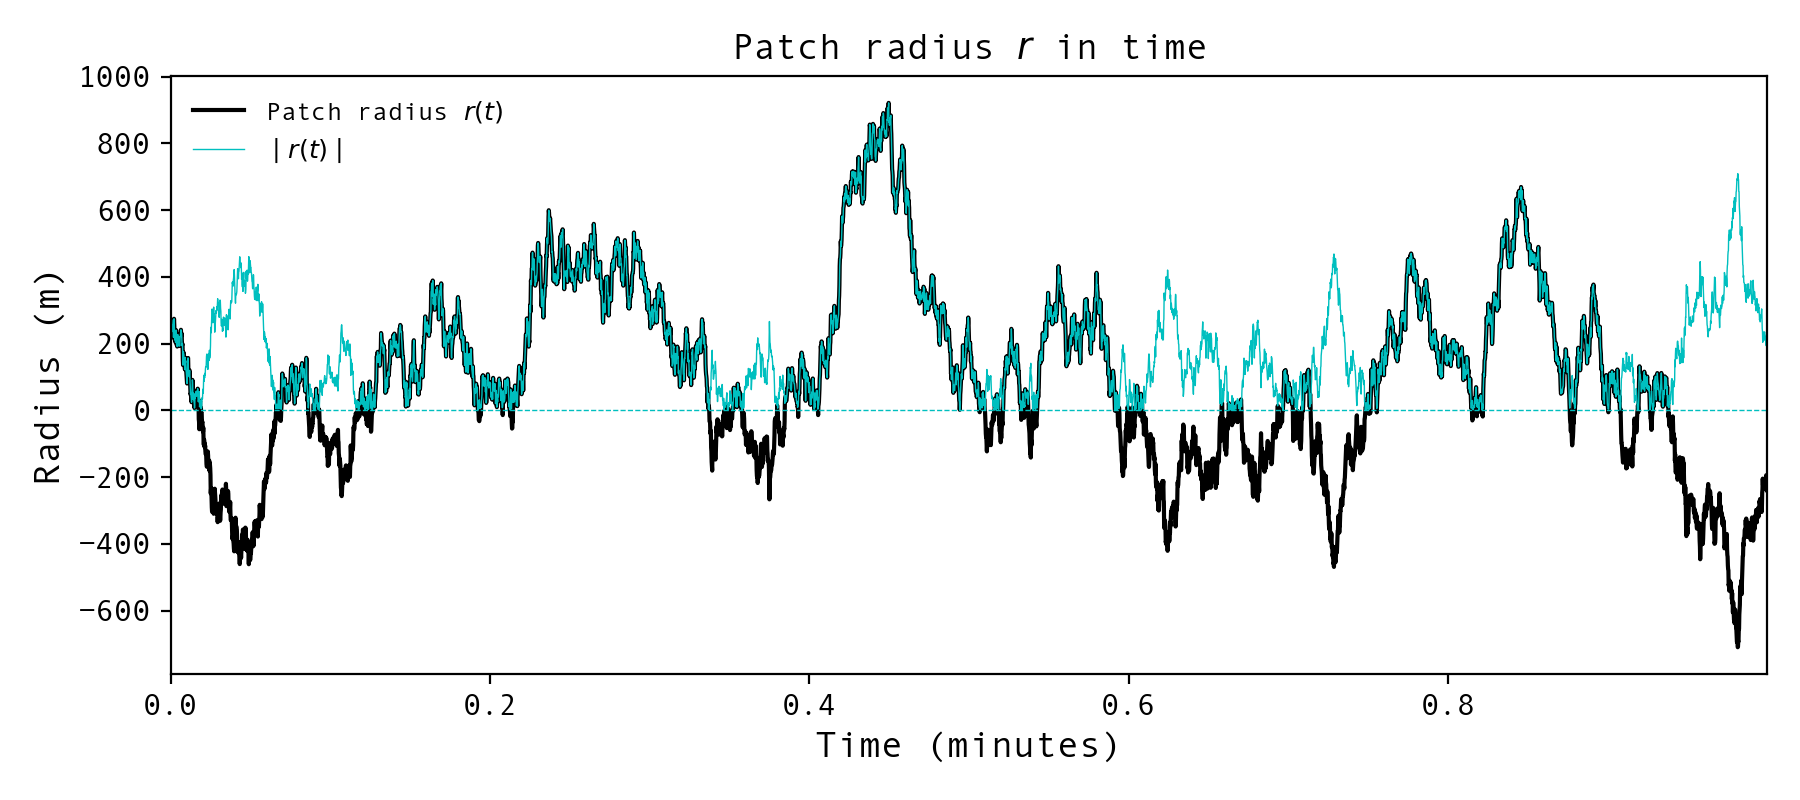

In [19]:
# Plot radius history (change time unit and time window in code below)
# ====================================================================
# Change plot parameters below:
# -----------------------------
# --> Choose time unit:
time_unit = "minutes"  # "days", "hours", "minutes", or "seconds"

# --> Choose time window:
tw_length = 60.     # time window length, in s (Nt*dt for complete history)
tb        = 1.         # beginning of time window, in s

te = tb + tw_length
tw = (time > tb) & (time < te)

# Apply parameters and plot
# -------------------------
# --> Convert to chosen time_unit:
if time_unit == 'seconds':
    conv_factor = 1
elif time_unit == "minutes":
    conv_factor = 60.
elif time_unit == "hours":
    conv_factor = 3600.
elif time_unit == "days":
    conv_factor = (24.*3600)

# --> Apply time window:
time_window = (time[tw] - time[tw][0])/conv_factor


# --> Actual plotting:
fig, ax = plt.subplots(figsize=(9,4))

ax.plot(time_window,r[tw],'k-',label=r'Patch radius $r(t)$')
ax.plot(time_window,abs(r[tw]),'c-',lw=.5,label=r'$\mid r(t)\mid$')
ax.axhline(0,c='c',ls='--',lw=.5)

ax.set_title(r'Patch radius $r$ in time')
ax.set_xlabel('Time ({:})'.format(time_unit))
ax.set_ylabel('Radius (m)')

ax.set_xlim((0,time_window[-1]))

ax.legend(frameon=False)

plt.tight_layout()
plt.show()

**Figure** *Variations of patch radius in time*
- As we can clearly see on the above graph, the radius turns negative from time to time. This might seem unphysical, but we will only consider $r(t)^2$ in the following, so it will pose no practical problem. We can simply consider its absolute value.

---


### From slip patch extensions/contraction to seismic radiation

**Seismic moment rate** $\dot{M_0}$ can here be expressed as $$\dot{M_0}(t) = \mu v_0 \pi r(t)^2.$$ The long term average of the moment rate is then $$E[\dot{M_0}]=\mu v_0 \pi \frac{\sigma^2}{2\alpha}.$$ The fact that the expected value of seismic moment rate is constant in time implies that **that the slow-earthquake duration is proportionnal to its moment**. This observation has been made for slow-earthquakes as a whole family [Ide et al., 2007], but seems to really hold only for the largest scales [Gomberg et al., 2016].

When assuming the contribution from P-waves is negligible, **the seismic energy rate** $\dot{E_s}(t)$ is simply proportionnal to the moment rate:

$$
d\dot{M_0}(t) \sim 2 \pi v_0 \mu r(t) \sigma F(t)$$
$$\dot{E_s}(t) \sim \frac{1}{10\pi \mu V_s^3} (\ddot{M_0}(t))^2 \sim \frac{2 v_0 \sigma^2}{5 V_s^3 dt} \dot{M_0} $$

Observations of tectonic tremor report that **the moment rate is proportionnal to the seismic energy rate** [Kanamori and Rivera, 2006]. As seen above, the model does reproduce this feature.

In [20]:
# Compute moment rate M0_dot
# --------------------------
M0_dot = mu * v0 * np.pi * r**2
M0_dot_mean = mu * v0 * np.pi * sigma**2/(2*alpha)

# --> Integrate it into seismic moment history, useful later
M0 = np.cumsum(M0_dot)*dt

<IPython.core.display.Javascript object>


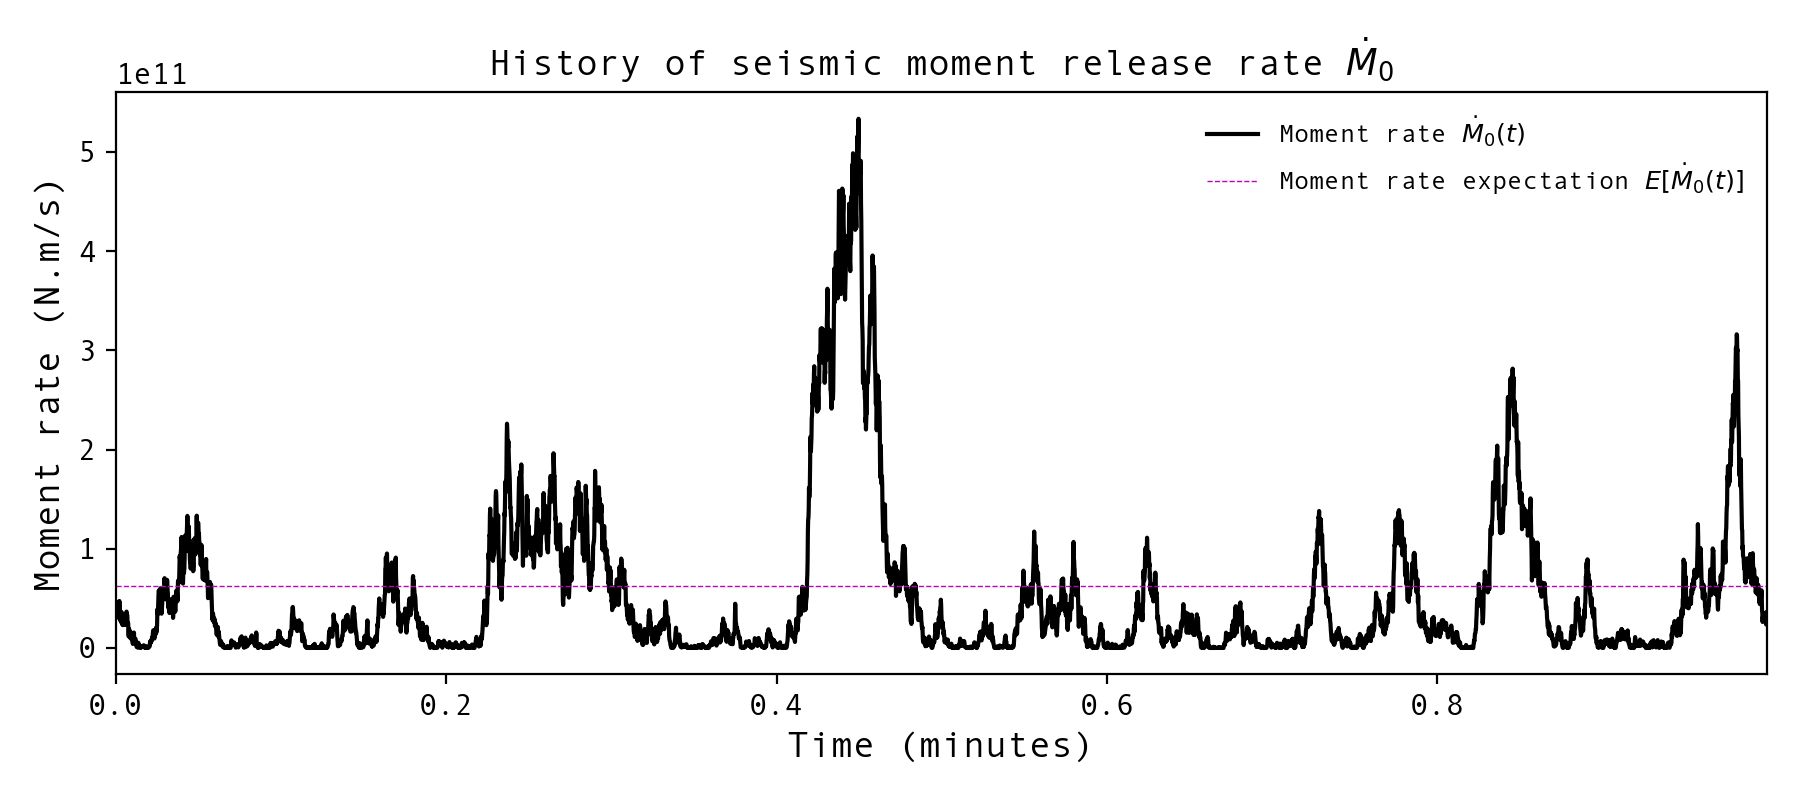

In [21]:
# Plot moment rate history (change time unit and time window in code below)
# =========================================================================
# Change plot parameters below:
# -----------------------------
# --> Choose time unit:
time_unit = "minutes"  # "days", "hours", "minutes", or "seconds"

# --> Choose time window:
tw_length = 60.     # time window length, in s (Nt*dt for complete history)
tb        = 1.         # beginning of time window, in s

te = tb + tw_length
tw = (time > tb) & (time < te)

# Apply parameters and plot
# -------------------------
# --> Convert to chosen time_unit:
if time_unit == 'seconds':
    conv_factor = 1
elif time_unit == "minutes":
    conv_factor = 60.
elif time_unit == "hours":
    conv_factor = 3600.
elif time_unit == "days":
    conv_factor = (24.*3600)

# --> Apply time window:
time_window = (time[tw] - time[tw][0])/conv_factor


# --> Actual plotting:
fig, ax = plt.subplots(figsize=(9,4))

ax.plot(time_window,M0_dot[tw],'k-',label=r'Moment rate $\dot{M}_0(t)$')
ax.axhline(M0_dot_mean,c='m',ls='--',lw=.5,label=r'Moment rate expectation $E[\dot{M}_0(t)]$')

ax.set_title(r'History of seismic moment release rate $\dot{M}_0$')
ax.set_xlabel('Time ({:})'.format(time_unit))
ax.set_ylabel('Moment rate (N.m/s)')

ax.set_xlim(0,time_window[-1])

ax.legend(frameon=False)

plt.tight_layout()
plt.show()

**Figure** *History of seismic moment release rate*

- For long-term ($T>\alpha^{-1}$), the mean moment rate is close to the theoretical expectation of moment rate. A lot of structure is visible: notice a few long episodes of moment release and a lot of much shorter, smaller events in terms of moment release. Those episodes can be thought of as discrete slow-earthquakes events.

---


Finally, using the expression for the seismic moment rate and its incremental variation, we can derive the **ground velocity time series** $\dot{u}(t)$ at a receiver located at a distance $R$ from the source [Aki and Richards, 2002]:

$$ \dot{u}(t) = \frac{2.4}{4\pi\mu R^2}\dot{M_0}(t - \frac{R}{V_s}) + \frac{0.63}{4\pi\mu V_s R}\ddot{M_0}(t - \frac{R}{V_s})$$

Let's first define a few functions that will be useful for processing the waveforms, and then generate the synthetic tremor waveform.

In [22]:
# Compute ground shaking induced by seismic energy radiation from the slow-earthquake patch
# =========================================================================================

# Compute time derivative of seismic moment rate
# ----------------------------------------------
M0_ddot = (M0_dot[1:] - M0_dot[:-1])/dt

# Compute ground motion velocity waveform
# ---------------------------------------
vel = 2.4/(4*np.pi*mu*R**2)*M0_dot[1:] + 0.63/(4*np.pi*mu*Vs*R)*M0_ddot

# Compute ground motion velocity spectrum
# ---------------------------------------
sp_vel    = abs(np.fft.fft(vel,len(vel)))
sp_vel_sm = smooth(sp_vel,50)
fq        = np.fft.fftfreq(len(vel),dt)

sp_vel    = sp_vel[fq>0]
sp_vel_sm = sp_vel_sm[fq>0]
fq        = fq[fq>0]

# Filter ground motion waveforms in relevant bands
# ------------------------------------------------
# hf - band --> Low-frequency earthquake signal, 1-8 Hz
hf_low, hf_high = (1,8)
vel_hf = butter_bandpass_filter(vel,hf_low,hf_high,1/dt,order=3)

# lf - band --> Very low-frequency earthquake signal, 0.03-0.2 Hz
lf_low, lf_high = (0.03,0.2)
vel_lf = butter_bandpass_filter(vel,lf_low,lf_high,1/dt,order=3)

<IPython.core.display.Javascript object>


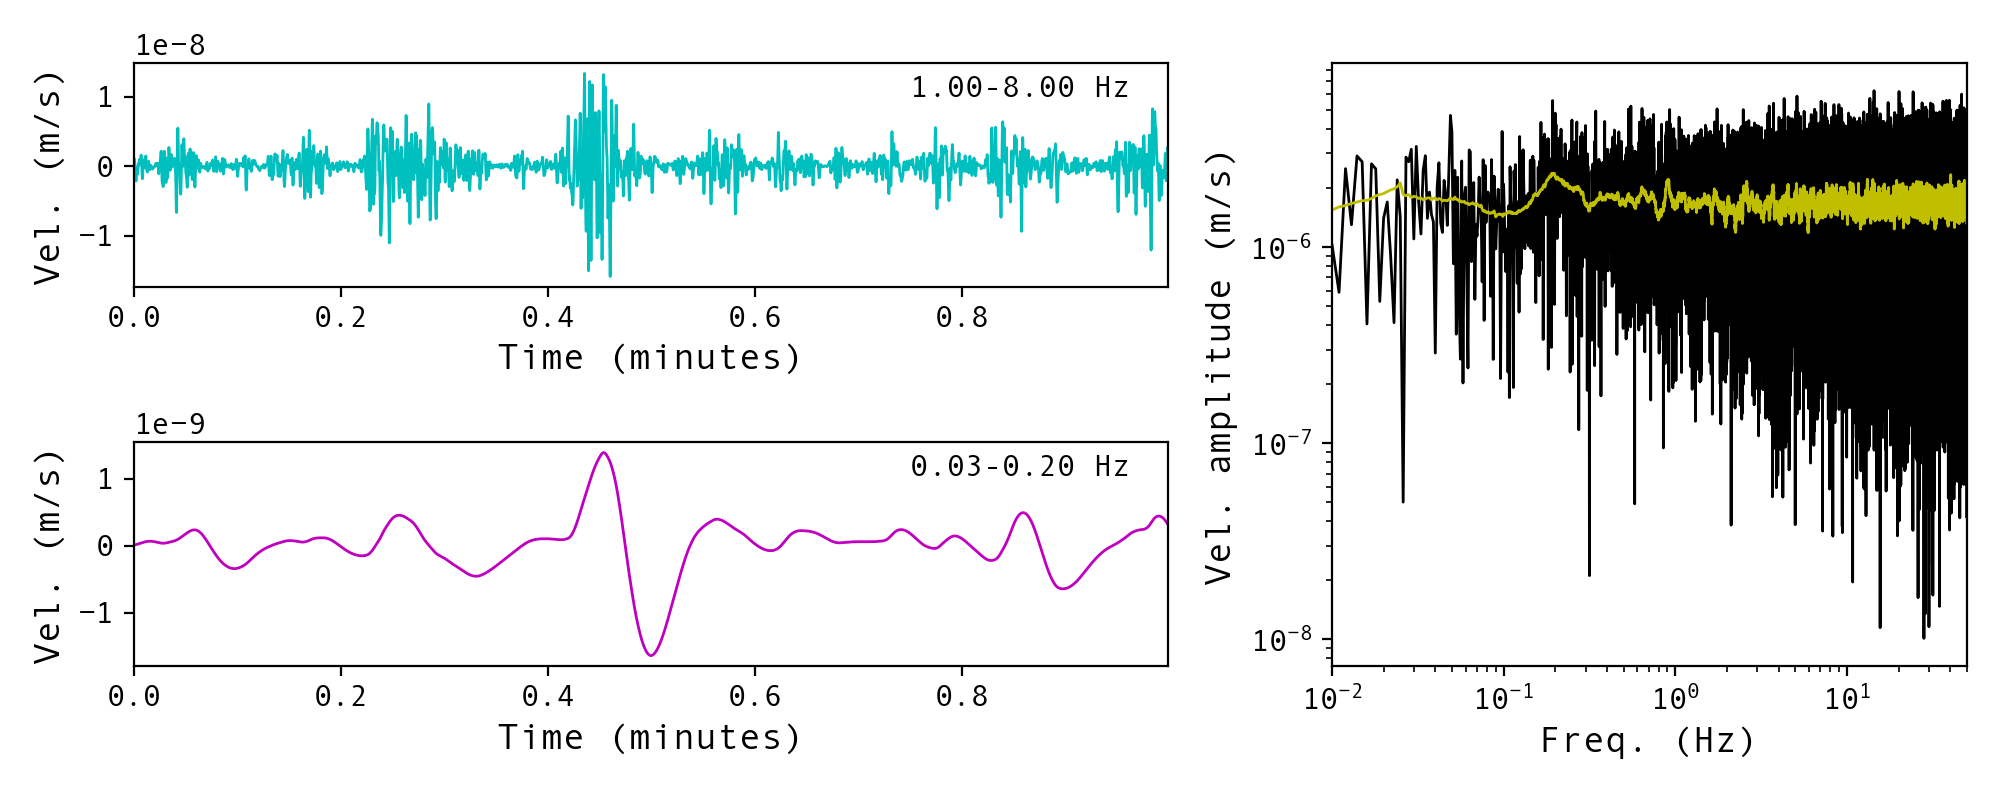

In [23]:
# Plot synthetic seismograms and their spectrum (change time window and time units in code below)
# ===============================================================================================
# Change plot parameters below:
# -----------------------------
# --> Choose time unit:
time_unit = "minutes"  # "days", "hours", "minutes", or "seconds"

# --> Choose time window:
tw_length = 60.     # time window length, in s (Nt*dt for complete history)
tb        = 1.         # beginning of time window, in s

te = tb + tw_length
tw = (time > tb) & (time < te)

# Apply parameters and plot
# -------------------------
# --> Convert to chosen time_unit:
if time_unit == 'seconds':
    conv_factor = 1
elif time_unit == "minutes":
    conv_factor = 60.
elif time_unit == "hours":
    conv_factor = 3600.
elif time_unit == "days":
    conv_factor = (24.*3600)

# --> Apply time window:
time_window = (time[tw] - time[tw][0])/conv_factor

# --> Actual plotting:
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(2,5)

hf_ax = fig.add_subplot(gs[0,:3])
lf_ax = fig.add_subplot(gs[1,:3])
sp_ax = fig.add_subplot(gs[:,3:])

#
hf_ax.plot(time_window,vel_hf[tw[1:]],'c-',lw=1.)
hf_ax.text(0.75,0.85,'{:.2f}-{:.2f} Hz'.format(hf_low,hf_high),transform=hf_ax.transAxes)
hf_ax.set_xlabel('Time ({:})'.format(time_unit))
hf_ax.set_ylabel('Vel. (m/s)')
hf_ax.set_xlim((0,max(time_window)))

#
lf_ax.plot(time_window,vel_lf[tw[1:]],'m-',lw=1.)
lf_ax.text(0.75,0.85,'{:.2f}-{:.2f} Hz'.format(lf_low,lf_high),transform=lf_ax.transAxes)
lf_ax.set_xlabel('Time ({:})'.format(time_unit))
lf_ax.set_ylabel('Vel. (m/s)')
lf_ax.set_xlim((0,max(time_window)))

#
sp_ax.loglog(fq,sp_vel,'k-',lw=1.,label='raw')
sp_ax.loglog(fq,sp_vel_sm,'y-',lw=1.,label='smoothed')
sp_ax.set_xlabel('Freq. (Hz)'.format(time_unit))
sp_ax.set_ylabel('Vel. amplitude (m/s)')
sp_ax.set_xlim((0.01,50))

plt.tight_layout()
plt.show()

**Figure** *Synthetic waveforms generated by seismic slip on the fault patch*
- These waveforms can be thought of as synthetic seismic tremor. The value of the damping parameter $\alpha$ has a strong influence on the shape on its spectrum: especially on the ratio of low-frequency to high-frequency amplitude components. For long damping times (small values of $\alpha$), low frequency waveforms have a high amplitude compared to higher-frequency waveforms.

---

### Detecting slow-earthquakes events, ideally and realistically

#### Low-frequency earthquakes (LFEs) and very low-frequency earthquakes (VLF) in the model
In the framework of this model, slow-earthquakes as we detect them seismically — LFEs and VLFEs [see Beroza and Ide, 2011, for complete review] – are discrete manifestations of a continuous process. They are bursts of seismic moment rate separated from the neighboring moment rate structures. In a noise-free situation, an event can be defined in time anything happening between two reversal of signs of the patch radius $r(t)$. Its duration is the time elapsed between those zero-crossings, its seismic moment is the integral of the seismic moment rate, also in between those zero crossings. With such a definition, at any time, a slow-earthquake is active.

In [24]:
# Detecting events in noise free-data
# -----------------------------------

# --> Locating sign reversals of the radius in time and computing event duration
print('Computing event durations...')
int_ev_times = [time[tt]+dt/2 for tt in range(1,Nt-1) if (np.sign(r[tt+1])!=np.sign(r[tt]))]
int_ev_times.insert(0,0)

ev_durations = np.array([int_ev_times[ii+1]-int_ev_times[ii] for ii in range(len(int_ev_times)-1)])

# --> For each event, get cumulative moment at the end of each event, and compute event seismic moment
print('Computing event moments...')
ev_end_moments   = [M0[tt+1] for tt in range(1,Nt-1) if (np.sign(r[tt+1])!=np.sign(r[tt]))]
ev_end_moments.insert(0,0)

ev_moments = np.array([ev_end_moments[ii+1]-ev_end_moments[ii] for ii in range(len(ev_end_moments)-1)])
print('Done!\n')

print('A total of {:} events are detected.'.format(len(ev_moments)))

Computing event durations...
Computing event moments...
Done!

A total of 2317 events are detected.


<IPython.core.display.Javascript object>


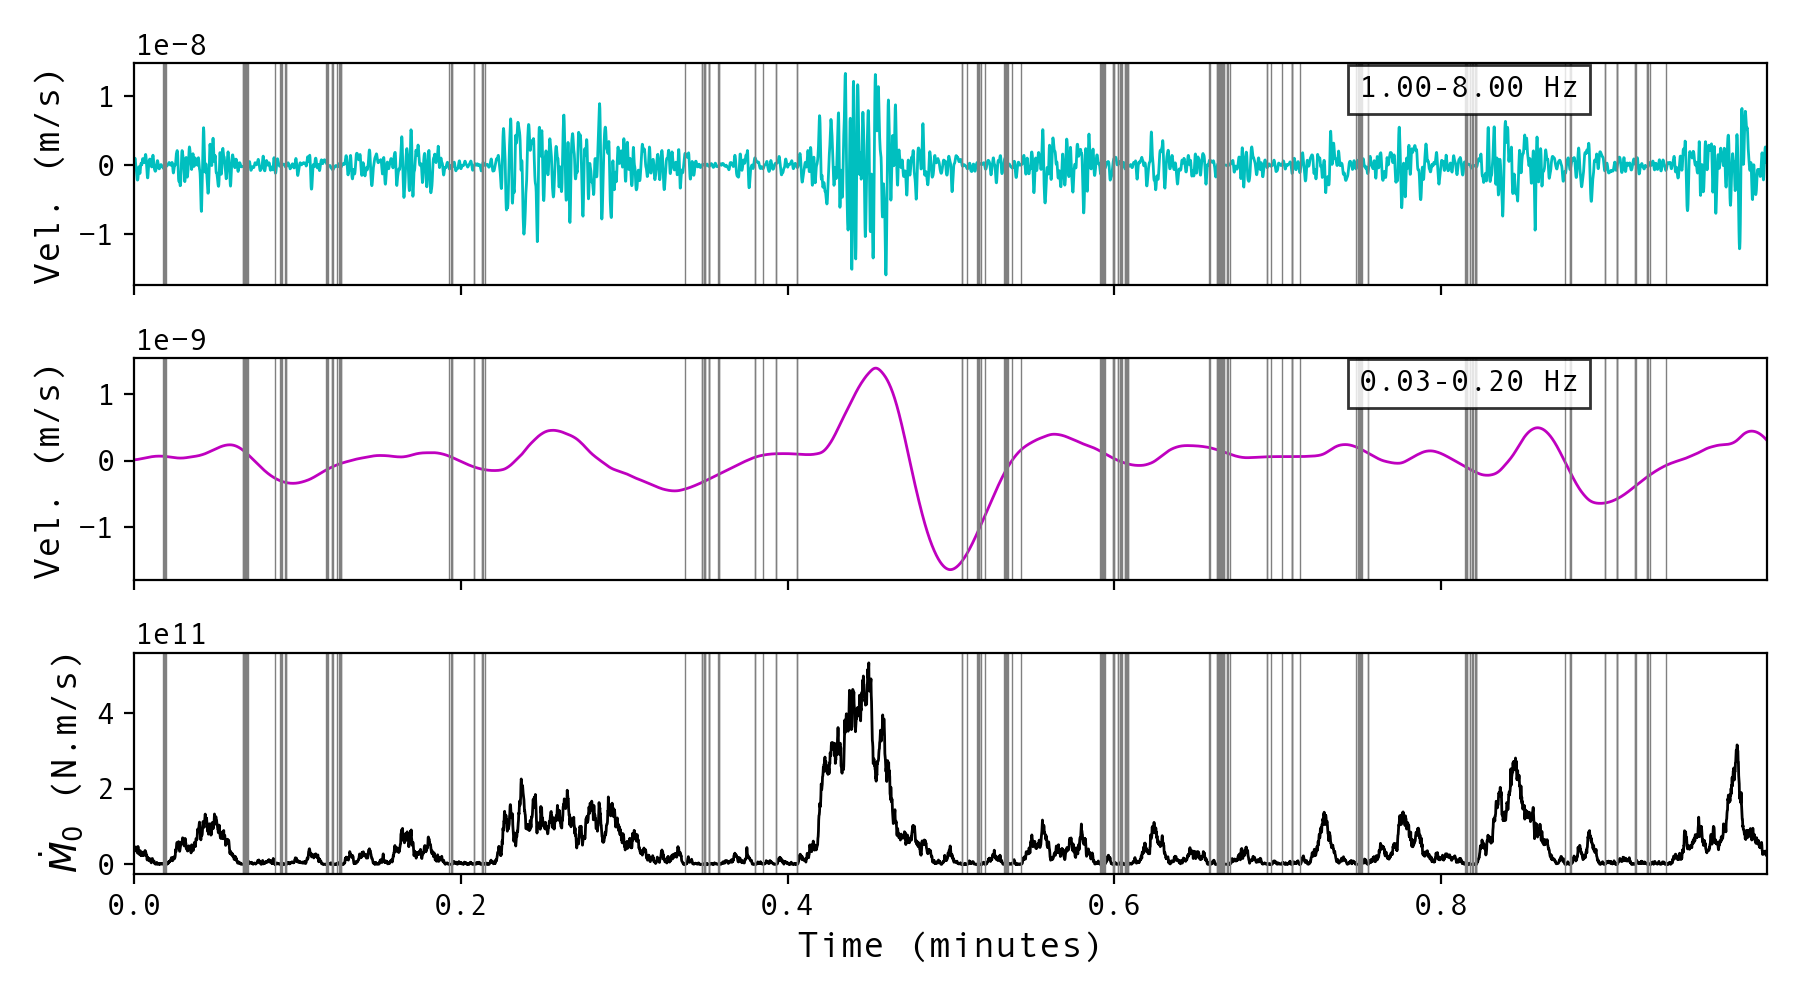

In [25]:
# Plot detection of theoretical events (change time window and time unit in code below)
# =====================================================================================
# Change plot parameters below:
# -----------------------------
# --> Choose time unit:
time_unit = "minutes"  # "days", "hours", "minutes", or "seconds"

# --> Choose time window:
tw_length = 60.     # time window length, in s (Nt*dt for complete history)
tb        = 1.         # beginning of time window, in s

te = tb + tw_length
tw = (time > tb) & (time < te)

# Apply parameters and plot
# -------------------------
# --> Convert to chosen time_unit:
if time_unit == 'seconds':
    conv_factor = 1
elif time_unit == "minutes":
    conv_factor = 60.
elif time_unit == "hours":
    conv_factor = 3600.
elif time_unit == "days":
    conv_factor = (24.*3600)

# --> Apply time window:
time_window = (time[tw] - time[tw][0])/conv_factor

# --> Actual plotting:
fig, ax = plt.subplots(3,1,sharex=True,figsize=(9,5))

# -->>Plot physical variables
ax[0].plot(time_window,vel_hf[tw[1:]],c='c',lw=1)
ax[1].plot(time_window,vel_lf[tw[1:]],c='m',lw=1)
ax[2].plot(time_window,M0_dot[tw],c='k',lw=1)

# -->> Show seismic events boundaries
for axi in ax:
    for ev_t in int_ev_times:
        ev_t_shifted = (ev_t - time[tw][0])/conv_factor
        if (ev_t_shifted>0) and (ev_t_shifted)<time_window[-1]:
            axi.axvline(ev_t_shifted,lw=.5,c='gray')

# -->> Add filter bands text
t = ax[0].text(0.75,0.85,'{:.2f}-{:.2f} Hz'.format(hf_low,hf_high),transform=ax[0].transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='k'))
t = ax[1].text(0.75,0.85,'{:.2f}-{:.2f} Hz'.format(lf_low,lf_high),transform=ax[1].transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='k'))


# -->> Add axes labels
ax[0].set_ylabel('Vel. (m/s)')
ax[1].set_ylabel('Vel. (m/s)')
ax[2].set_ylabel(r'$\dot{M}_0$ (N.m/s)')
ax[2].set_xlabel('Time ({:})'.format(time_unit))
ax[2].set_xlim(time_window[0],time_window[-1])

plt.tight_layout()
plt.show()

**Figure** *All events that could ideally be detected*
- The moment release on the patch is continuous, discrete "events" are defined by inversion of the sign of the patch radius. Events boundaries (patch's radius inversions) are represented as vertical gray lines. The shorter events do not appear in the lower frequency band, but for some of them, some structure can be seen in the higher frequency band. The appearance of very low frequency events depends strongly on the damping time $\alpha^{-1}$. Try changing it to see how they appear!

---

For classical earthquakes, seismic moments are proportionnal to the cube of the event duration: $M_0 \propto T^{3}$ [Allmann and Shearer, 2009]. This law is called self similarity of slow earthquakes, it gives us information on the way an earthquake releases energy in time. Self-similar ruptures have the property to be scale invariant, in particular, the rupture velocity and stress drop they allow are independent of the seismic moment. Let's see how seismic moment scales with duration for the ideal detections.

<IPython.core.display.Javascript object>


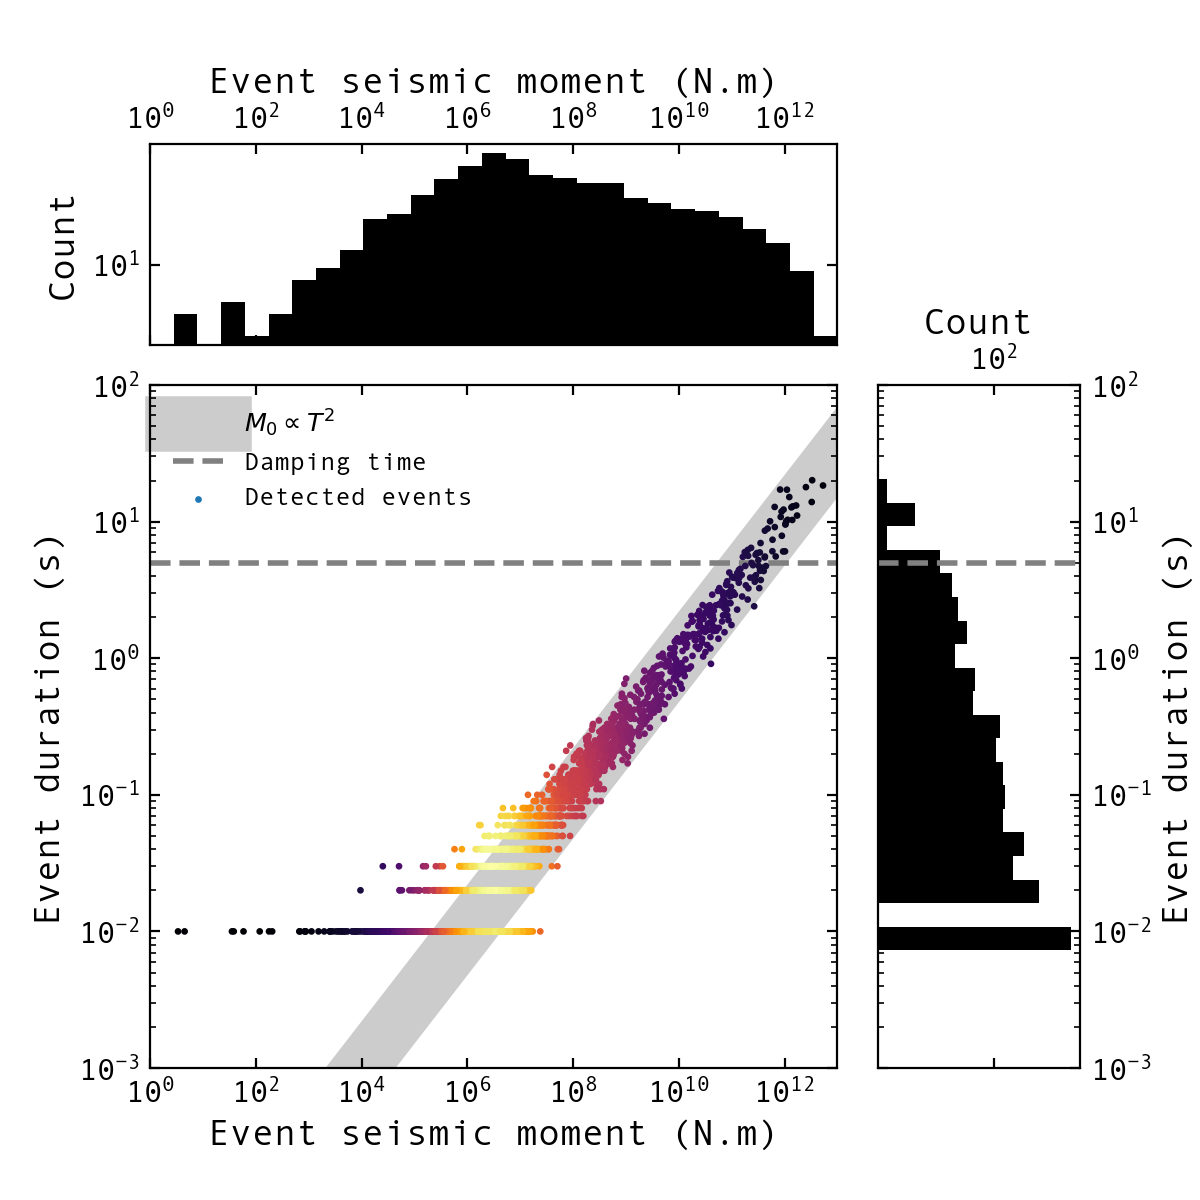

In [26]:
# Plot event moment-duration distribution
# ---------------------------------------


# --> Get point density
density_TM0 = density(ev_moments,ev_durations)

# --> Compute two points on M0^1/2 ~ T to plot it
M0_med,T_med = (np.median(ev_moments),np.median(ev_durations))
T_max = dt/10
T_min = 10**np.ceil(np.log10(ev_durations.max()))
M0_min = M0_med / T_med**2 * T_min**2
M0_max = M0_med / T_med**2 * T_max**2


# --> Define histogram bins and plot limits
xlim    = (10**np.floor(np.log10(ev_moments.min())),10**np.ceil(np.log10(ev_moments.max())))
ylim    = (10**np.floor(np.log10(ev_durations.min())),10**np.ceil(np.log10(ev_durations.max())))
M0_bins = np.logspace(np.log10(xlim[0]),np.log10(xlim[1]),num=30)
T_bins  = np.logspace(np.log10(ylim[0]),np.log10(ylim[1]),num=30)

# --> Create plot
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(4,4)

M0_ax   = fig.add_subplot(gs[0,:3])
T_ax    = fig.add_subplot(gs[1:,3])
full_ax = fig.add_subplot(gs[1:,:3])

M0_ax.tick_params(top=True,bottom=True,right=True,labelbottom=False,labeltop=True,direction='in',\
                  which='both')
T_ax.tick_params(top=True,bottom=True,right=True,left=True,labelbottom=False,labeltop=True,\
                 labelleft=False,labelright=True,direction='in',which='both')
full_ax.tick_params(top=True,bottom=True,left=True,right=True,direction='in',which='both')

full_ax.set_ylabel('Event duration (s)')
full_ax.set_xlabel('Event seismic moment (N.m)')

M0_ax.set_ylabel('Count')
M0_ax.set_xlabel('Event seismic moment (N.m)')
M0_ax.xaxis.set_label_position('top')

T_ax.set_xlabel('Count')
T_ax.set_ylabel('Event duration (s)')
T_ax.yaxis.set_label_position('right')
T_ax.xaxis.set_label_position('top')

M0_ax.hist(ev_moments, bins=M0_bins,fc='k')
T_ax.hist(ev_durations,bins=T_bins,fc='k',orientation='horizontal')
full_ax.scatter(ev_moments,ev_durations,s=2,c=density_TM0,cmap='inferno',zorder=10,label='Detected events')
#full_ax.loglog(M0,time,c='purple',label=r'Cum. $M_0$',zorder=15)
full_ax.loglog([M0_min,M0_max],[T_min,T_max],c=[0,0,0,.2],lw=20,ls='-',label=r'$M_0\propto T^2$')

full_ax.axhline(1./alpha,c='gray',ls='--',lw=2.,label='Damping time')

T_ax.axhline(1./alpha,c='gray',ls='--',lw=2.,label='Damping time')

M0_ax.set_xscale('log')
M0_ax.set_yscale('log')
T_ax.set_xscale('log')
T_ax.set_yscale('log')
full_ax.set_xscale('log')
full_ax.set_yscale('log')
    
M0_ax.set_xlim(xlim)
full_ax.set_xlim(xlim)
full_ax.set_ylim(ylim)
T_ax.set_ylim(ylim)

full_ax.legend(frameon=False)

plt.show()

**Figure** *Magnitude-duration distribution for ideally detected LFEs and VLFEs*
- The ideally detected seismic events are spread over a continuous band of durations, up to 10 times the damping time $\alpha^{-1}$. They roughly follow a $M_0\propto T^{2}$ scaling law.

---

##### Bad luck, noise-free data is not a thing...
In reality, only events with a moment rate reaching a certain threshold can be detected. The study by Ide (2008) uses a threshold of $5\times10^{11} N.m.s^{-1}$. Similarly to the theoretical case of a noise-free detection, events are defined by the moment release in periods when the moment rate is higher than the detection threshold. Their duration and seismic moment are calculated using this definition.

In [31]:
# --> Choose your threshold
threshold = 5e11  # detection moment rate threshold, N.m/s

In [32]:
# Detecting events with a realistic moment release rate threshold
# ---------------------------------------------------------------

M0_dot_det = M0_dot - threshold

# --> Locating sign reversals of the radius in time and computing event duration
print('Computing event durations...')
evt_start = [time[tt]+dt/2 for tt in range(1,Nt-1) if (np.sign(M0_dot_det[tt+1])-np.sign(M0_dot_det[tt]))==2]
evt_end   = [time[tt]+dt/2 for tt in range(1,Nt-1) if (np.sign(M0_dot_det[tt+1])-np.sign(M0_dot_det[tt]))==-2]

evt_durations = np.array([evt_end[ii]-evt_start[ii] for ii in range(len(evt_end))])

# --> For each event, get cumulative moment at the end of each event, and compute event seismic moment
print('Computing event moments...')
evt_start_moments = [M0[tt+1] for tt in range(Nt-1) if (np.sign(M0_dot_det[tt+1])-np.sign(M0_dot_det[tt]))==2]
evt_end_moments   = [M0[tt+1] for tt in range(Nt-1) if (np.sign(M0_dot_det[tt+1])-np.sign(M0_dot_det[tt]))==-2]

evt_moments = np.array([evt_end_moments[ii]-evt_start_moments[ii] for ii in range(len(evt_end_moments))])
print('Done!\n')

print('Using a detection threshold of {:.2} N.m/s, a total of {:} events are detected'.format(threshold,len(evt_moments)))

Computing event durations...
Computing event moments...
Done!

Using a detection threshold of 5e+11 N.m/s, a total of 34 events are detected


<IPython.core.display.Javascript object>


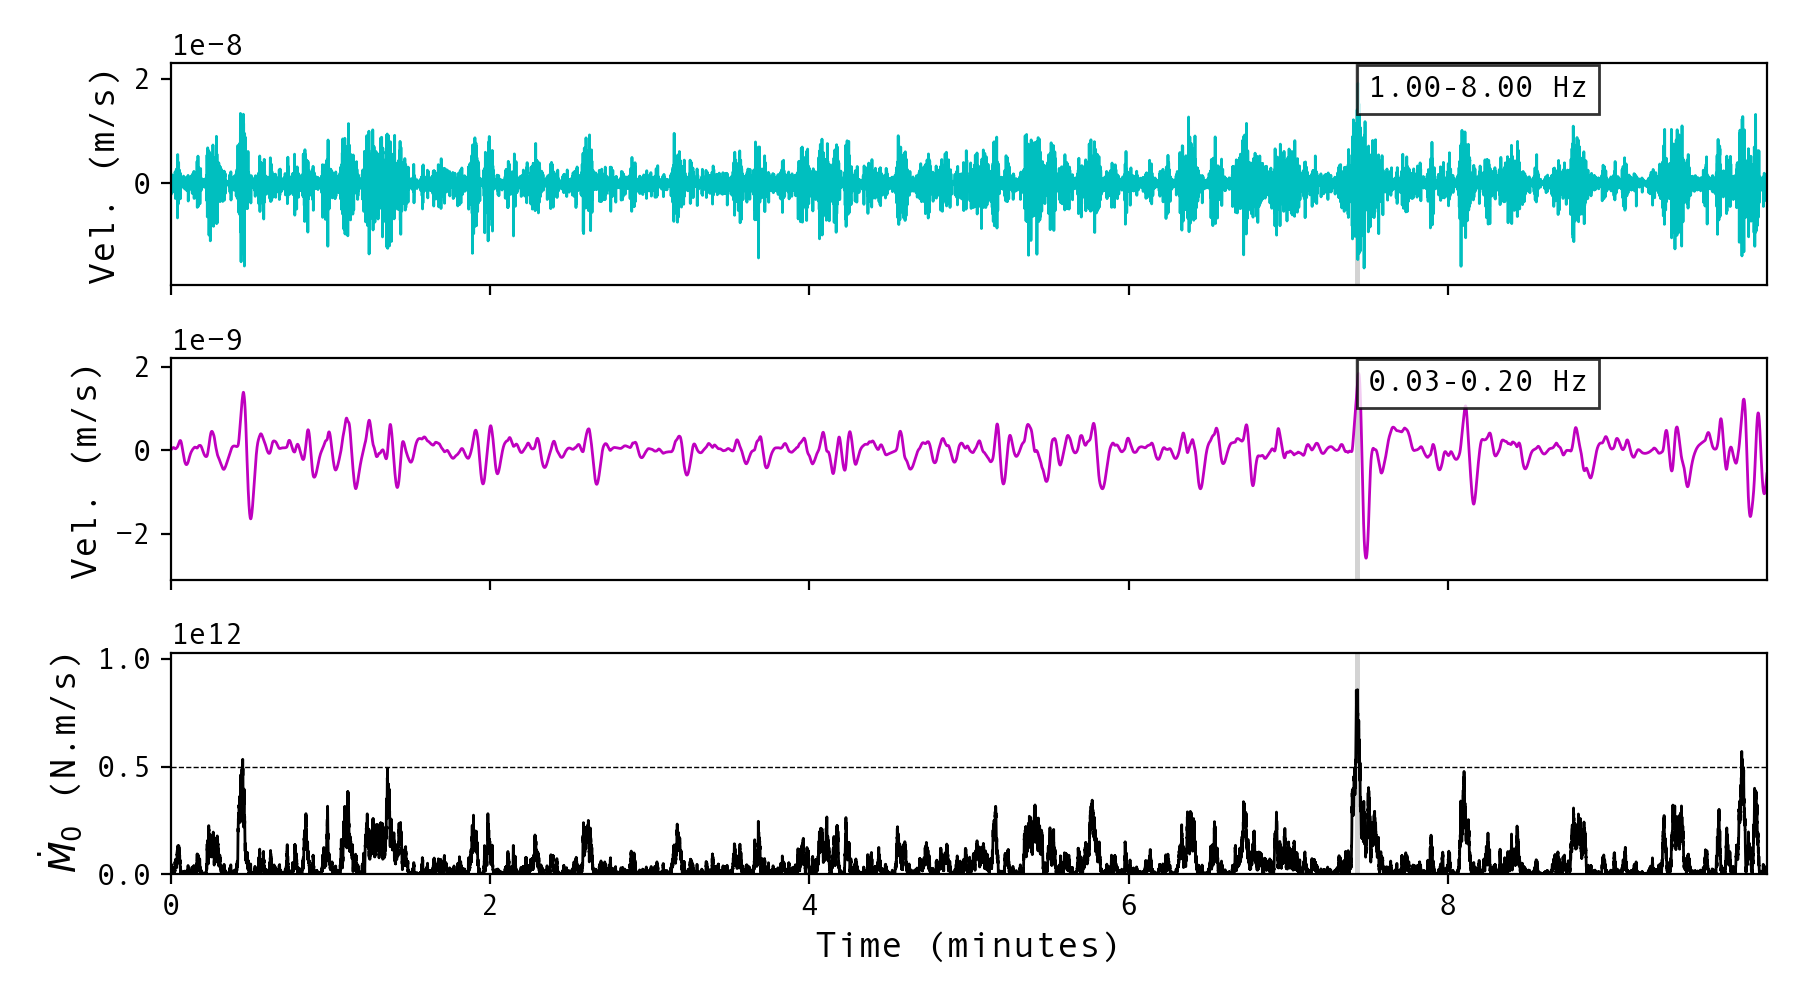

In [33]:
# Plot realistic detection events (change time window and time unit in code below)
# ================================================================================
# Change plot parameters below:
# -----------------------------
# --> Choose time unit:
time_unit = "minutes"  # "days", "hours", "minutes", or "seconds"

# --> Choose time window:
tw_length = 10*60.     # time window length, in s (Nt*dt for complete history)
tb        = 1.         # beginning of time window, in s

te = tb + tw_length
tw = (time > tb) & (time < te)

# Apply parameters and plot
# -------------------------
# --> Convert to chosen time_unit:
if time_unit == 'seconds':
    conv_factor = 1
elif time_unit == "minutes":
    conv_factor = 60.
elif time_unit == "hours":
    conv_factor = 3600.
elif time_unit == "days":
    conv_factor = (24.*3600)

# --> Apply time window:
time_window = (time[tw] - time[tw][0])/conv_factor

# --> Actual plotting:
fig, ax = plt.subplots(3,1,sharex=True,figsize=(9,5))

# -->> Plot physical variables
ax[0].plot(time_window,vel_hf[tw[1:]],c='c',lw=1)
ax[1].plot(time_window,vel_lf[tw[1:]],c='m',lw=1)
ax[2].plot(time_window,M0_dot[tw],c='k',lw=1)
ax[2].axhline(threshold,ls='--',c='k',lw=.5)

# -->> Show seismic events boundaries
evt_start_shifted = (evt_start - time[tw][0])/conv_factor
event_boxes = [Rectangle( (st,-1), dur, 2*M0_dot.max())
               for st, dur in zip(evt_start_shifted, evt_durations/conv_factor)]
for axi in ax:
    event_pc = PatchCollection(event_boxes, facecolor='lightgray', edgecolor=None,axes=axi)
    axi.add_collection(event_pc)

# -->> Add filter bands text
t = ax[0].text(0.75,0.85,'{:.2f}-{:.2f} Hz'.format(hf_low,hf_high),transform=ax[0].transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='k'))
t = ax[1].text(0.75,0.85,'{:.2f}-{:.2f} Hz'.format(lf_low,lf_high),transform=ax[1].transAxes)
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='k'))

# -->> Add axes labels
ax[0].set_ylabel('Vel. (m/s)')
ax[1].set_ylabel('Vel. (m/s)')
ax[2].set_ylabel(r'$\dot{M}_0$ (N.m/s)')
ax[2].set_xlabel('Time ({:})'.format(time_unit))

# -->> Fix axes limits
ax[0].set_ylim((1.2*vel_hf[tw[1:]].min(),1.2*vel_hf[tw[1:]].max()))
ax[1].set_ylim((1.2*vel_lf[tw[1:]].min(),1.2*vel_lf[tw[1:]].max()))
ax[2].set_ylim((0,1.2*M0_dot[tw].max()))
ax[2].set_xlim(time_window[0],time_window[-1])

plt.tight_layout()
plt.show()

**Figure** *Detection of events with a threshold*
- This time, events are defined by moment release that exceeds a rate of a certain threshold, figured by the black dashed line in the moment release rate history, at the bottom of the figure. This time, we see that this criterion really picks up apparent structure in the ground shaking waveforms, especially in the higher frequency band (LFEs). It is easy to see that the detected events now have a shorter duration than the length of the ideal event that underlies it. In some way, one could say that LFEs are detected as peaks in the moment release of VLFEs.
---

#### Long-term, geodetically detected slow-earthquakes: slow-slip events (SSE) and shorter slip transients

Long term slow-earthquakes like slow-slip events are detected using geodetical measurements of surface deformation (by GPS, InSAR, strainmeters etc) and more and more, the low-frequency earthquake activity is used as a proxy to locate short slow-slip transients and dig them out of geodetical noise. In the BSE model, as the stochastic process is active indefinately, the moment-duration history of **any** long-term slow-earthquake ($\Delta T_{SEQ} > \alpha^{-1}$) is represented by the cumulative moment in time of a run. While the long-term process is active, its seismic manifestation is seismic tremor, with many "discrete" events (LFEs and VLFEs) than can be detected within.

### A scaling low for Brownian slow-earthquakes?

Let's see how Brownian slow-earthquakes duration scales with their moment. As pointed out before, long-term slow-earthquakes are any given section of the simulated process. Their moment-duration characteristic distribution can be simply represented by the history of moment release in time. Let's plot it along with the moment-duration distribution of ideal and realistic detections for this run.

<IPython.core.display.Javascript object>


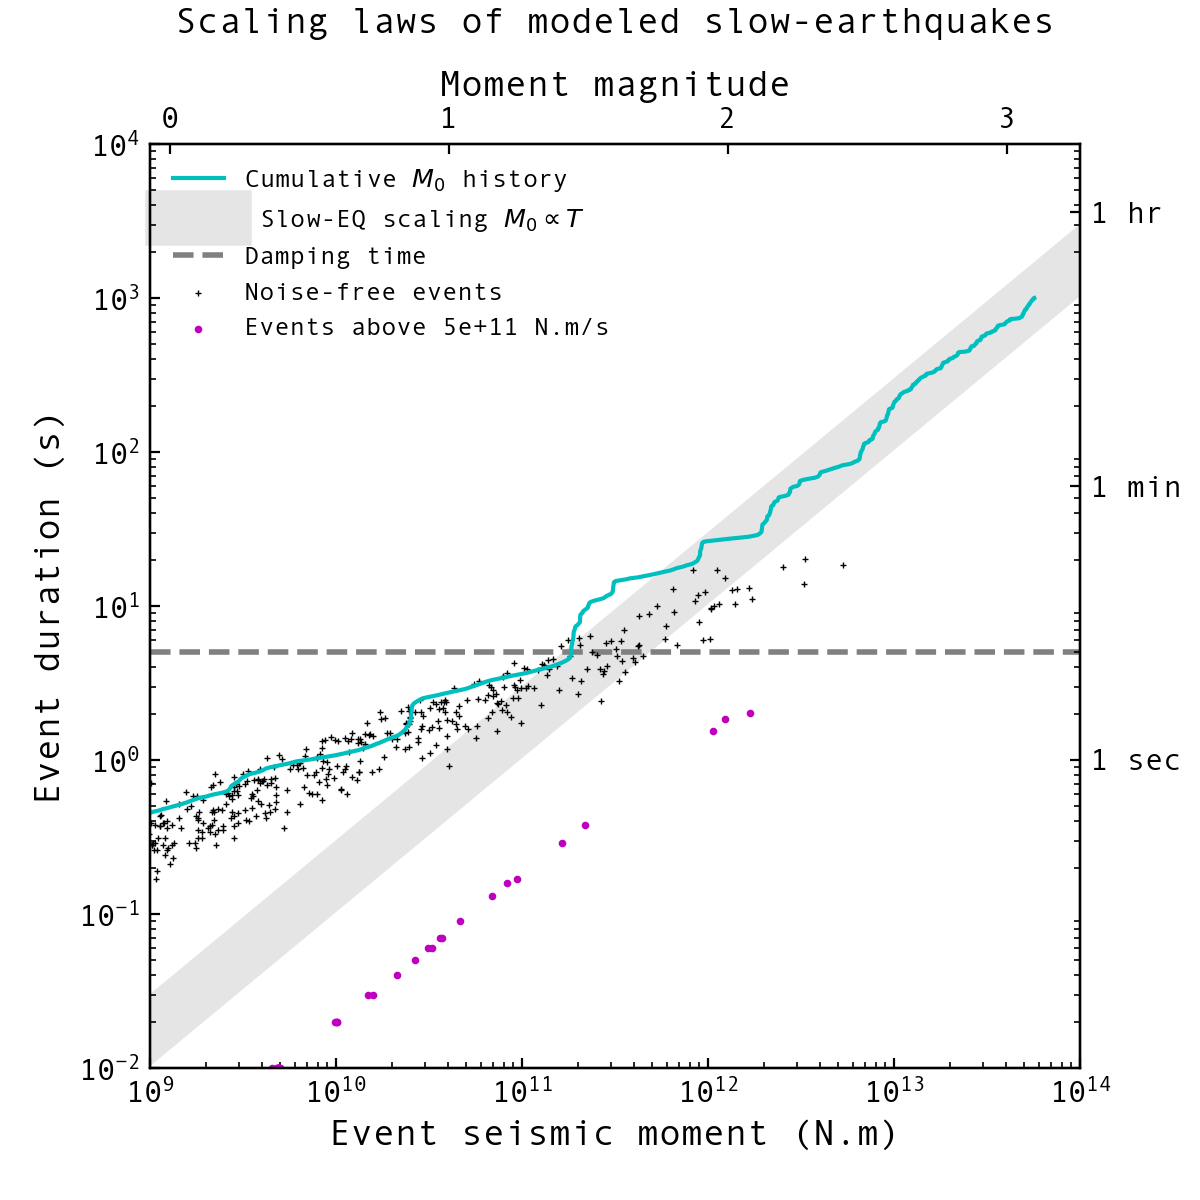

In [34]:
# Moment-duration relationship for Brownian slow-earthquakes
# ---------------------------------------------
# --> Get point density
density_TM0_t = density(evt_moments,evt_durations)
density_TM0 = density(ev_moments,ev_durations)

# --> Compute two points on M0^1/2 ~ T to plot it
M0_aim,T_aim = (M0[-1],Nt*dt)
T_min = dt/10
T_max = 10**np.ceil(np.log10(M0[-1]))
M0_min = M0_aim / T_aim * T_min
M0_max = M0_aim / T_aim * T_max


# --> Define histogram bins and plot limits
xlim    = (10**np.floor(np.log10(evt_moments.min())),10**np.ceil(np.log10(M0[-1])))
ylim    = (dt,10*Nt*dt)

# --> Create plot
fig, ax = plt.subplots(figsize=(6,6))
ax.tick_params(top=True,bottom=True,left=True,right=True,direction='in',which='both')

ax.set_title('Scaling laws of modeled slow-earthquakes',pad=40)
ax.set_ylabel('Event duration (s)')
ax.set_xlabel('Event seismic moment (N.m)')

ax.scatter(ev_moments,ev_durations,s=6,lw=.5,c='k',marker='+',cmap='inferno',zorder=10,label='Noise-free events')
ax.scatter(evt_moments,evt_durations,s=3,c='m',zorder=10,label='Events above {:.0e} N.m/s'.format(threshold))

ax.loglog(M0,time,c='c',label=r'Cumulative $M_0$ history',zorder=15)
ax.loglog([M0_min,M0_max],[T_min,T_max],c=[0,0,0,.1],lw=20,ls='-',label=r' Slow-EQ scaling $M_0\propto T$',zorder=0)

ax.axhline(1./alpha,c='gray',ls='--',lw=2.,label='Damping time')

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.legend(frameon=False)


# -->> Add moment magnitude scale
mw = lambda m0 : 2/3*np.log10(m0) - 6.07
ax_mw = ax.twiny()

ax_mw.set_xlabel(('Moment magnitude'))
ax_mw.tick_params(direction='in')

ticks  = np.arange(0,10,1)
ax_mw.set_xticks(ticks)
ax_mw.set_xlim(mw(xlim[0]),mw(xlim[1]))

# -->> Add more readable durations
ax_T = ax.twinx()
ax_T.set_yscale('log')

ticks  = [1,60,3600,24*3600,30*24*3600,6*30*24*3600,365*24*3600]
labels = ['1 sec','1 min','1 hr','1 day','1 mth', '6 mth', '1 yr']
ax_T.set_yticks(ticks)
ax_T.set_yticklabels(labels)
ax_T.set_ylim(ylim)
ax_T.tick_params(direction='in',which='both')

plt.show()

**Figure** *Moment-duration distribution of Brownian slow earthquakes*
- The distribution of seismically detected events (dots for realistic detections, crosses for ideal detections) is shown along the moment release history of this run, representing the time dependency of moment release for long-term slow-earthquakes, as slow-slip events. The gray band represent a suggested scaling for slow-earthquakes $M_0 \propto T$, based on observations of LFEs, VLFEs and slow-slip events of various sizes [Ide et al, 2008]. Two major observations can be made:
    * **(i)** on long term scales (above the damping time, $\alpha^{-1}$), the stochastic process converges toward the $M_0 \propto T$ scaling, as shown in a previous section
    
    * **(ii)** on shorter time scales, for seismic events, the fact that a threshold is used to detect them introduces a bias in the moment-duration scaling, pushing it towards a $M_0 \propto T$ scaling, whereas in reality, the modeled events would align along a $M_0 \propto T^2$ scaling. As mentionned before, events are detected with a much lower duration and somewhat lower moment than the ideal moment. With real events, it would mean that some LFEs are detected as peakes of moment release within the undetectable moment release of a VLFE.
---

### Let's try to wrap this up...

#### How does the model do with respect to observations?
This stochastic model, with very few parameters and physical modelization, reproduces a few observations made on slow-earthquakes: 
* Proportionnality of the radiated seismic energy and seismic moment release [Kanamori and Rivera, 2006]
* Proportionnality of seismic moment and duration of the long-term events [Ide et al., 2007]

#### What are its limitations?
On the short scale, it is tricky to evaluate if the conclusions it provides as to the moment-duration scaling are consistent with observations, first due to the bias that real-world detection is predicted to have by the model, and second due to the band limitation of most observations, which often focus on certain frequency bands to detect events.

The absence of any physical description of the process really becomes problematic when interpreting LFEs and VLFEs as the smaller features the model produces. In the model they are only small stochastic variations of a rupture patch radius. A more realistic description of how a fault patch behaves depending on the slip rate around it would need to be supplemented to either support or reject the smaller scale description.

#### As a conclusion, slow-earthquakes are fun
In any case, this model allows to play with the different scales of slow-earthquakes and to conceive how we currently picture their relationship. The long-term slip process is what drives the seismic activity on the patch: events appear when slip accelerates enough to produce detectable seismic events. Low-frequency seismic events are thus a simple, discrete manifestation of an underlying aseismic slip process, which can only be measured geodetically on longer scales, and manifests as long, noisy seismic tremor. It is a great toy-model to practice the understanding of slow-earthquakes processes.


---

### References

+ Aki, K., & Richards. (2002). Quantitative Seismology (Second Edition).
+ Allmann, B. P., & Shearer, P. M. (2009). Global variations of stress drop for moderate to large earthquakes: GLOBAL STRESS DROP VARIATIONS. Journal of Geophysical Research: Solid Earth, 114(B1). https://doi.org/10.1029/2008JB005821
+ Beroza, G. C., & Ide, S. (2011). Slow Earthquakes and Nonvolcanic Tremor. Annual Review of Earth and Planetary Sciences, 39(1), 271–296. https://doi.org/10.1146/annurev-earth-040809-152531
+ Frank, W. B., & Brodsky, E. E. (2019). Daily measurement of slow slip from low-frequency earthquakes is consistent with ordinary earthquake scaling. Science Advances, 5(10), eaaw9386. https://doi.org/10.1126/sciadv.aaw9386
+ Gomberg, J., Wech, A., Creager, K., Obara, K., & Agnew, D. (2016). Reconsidering earthquake scaling: RECONSIDERING EARTHQUAKE SCALING. Geophysical Research Letters, 43(12), 6243–6251. https://doi.org/10.1002/2016GL069967
+ Ide, S. (2008). A Brownian walk model for slow earthquakes. Geophysical Research Letters, 35(17). https://doi.org/10.1029/2008GL034821
+ Ide, S., Beroza, G. C., Shelly, D. R., & Uchide, T. (2007). A scaling law for slow earthquakes. Nature, 447(7140), 76–79. https://doi.org/10.1038/nature05780
+ Ide, S., & Maury, J. (2018). Seismic Moment, Seismic Energy, and Source Duration of Slow Earthquakes: Application of Brownian slow earthquake model to three major subduction zones. Geophysical Research Letters, 45(7), 3059–3067. https://doi.org/10.1002/2018GL077461
+ Kanamori, H., & Rivera, L. (2006). Energy partitioning during an earthquake. In R. Abercrombie, A. McGarr, H. Kanamori, & G. Di Toro (Eds.), Geophysical Monograph Series (Vol. 170, pp. 3–13). American Geophysical Union. https://doi.org/10.1029/170GM03
+ Kostoglodov, V., Husker, A., Shapiro, N. M., Payero, J. S., Campillo, M., Cotte, N., & Clayton, R. (2010). The 2006 slow slip event and nonvolcanic tremor in the Mexican subduction zone. Geophysical Research Letters, 37(24). https://doi.org/10.1029/2010GL045424
+ Thomas, A. M., Beroza, G. C., & Shelly, D. R. (2016). Constraints on the source parameters of low-frequency earthquakes on the San Andreas Fault: Source Parameters of LFEs on the SAF. Geophysical Research Letters, 43(4), 1464–1471. https://doi.org/10.1002/2015GL067173